In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from models import RVAEModel, ClassModel, CRGANModel
from data_utils import DataFactory
from fastdtw import fastdtw
import fancyimpute
tf.enable_eager_execution()
%matplotlib inline

/home/malzantot/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/malzantot/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/malzantot/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/malzantot/anaconda3/lib/python3.6/site-packages/tensorflow/python/f

In [2]:
CHECKPOINT_DIR = './save/har_physgan/07_28_17_55'
AUX_CHECKPOINT_DIR = './save/har_lstm/07_22_21_13'


In [3]:
ecg_train, ecg_test, metadata = DataFactory.create_dataset('har')

(array([0, 1, 2, 3, 4, 5], dtype=int32), array([1226, 1073,  986, 1286, 1374, 1407]))
(7352, 32, 6)
(array([0, 1, 2, 3, 4, 5], dtype=int32), array([496, 471, 420, 491, 532, 537]))
(2947, 32, 6)


In [4]:

model = RVAEModel(enc_rnn_units=128,z_dim=16,dec_rnn_units=128,num_feats=metadata.num_feats,num_labels=metadata.num_labels)
#model = CRGANModel(num_feats=1,num_labels=2,z_dim=8,num_units=128)

aux_model = ClassModel(num_feats=6,num_labels=6)

W0813 20:19:05.016241 140211606701888 deprecation_wrapper.py:119] From /home/malzantot/Nesl/bio_gan/models.py:103: The name tf.keras.layers.CuDNNGRU is deprecated. Please use tf.compat.v1.keras.layers.CuDNNGRU instead.



In [5]:
checkpoint = tf.train.Checkpoint(model=model)
status = checkpoint.restore(tf.train.latest_checkpoint(CHECKPOINT_DIR))

aux_checkpoint = tf.train.Checkpoint(model=aux_model)
aux_checkpoint.restore(tf.train.latest_checkpoint(AUX_CHECKPOINT_DIR))

In [6]:
def evaluate_accuracy(aux_model, data_x, data_y):
    preds = tf.arg_max(aux_model(data_x),dimension=1)
    accuracy_metric = tf.keras.metrics.Accuracy()
    accuracy_metric.update_state(data_y, preds)
    return accuracy_metric.result().numpy()

### Evaluate

In [7]:
def get_testset(test_dataset, test_size=200, mask_type='mar', mask_prob = 0.5):
    test_x, test_y = next(iter(test_dataset.shuffle(1000).batch(test_size)))
    test_masks = []
    test_originals = []
    test_inputs = []
    test_labels = []
    for i in range(test_x.shape[0]):
        rand_test_idx = i# np.random.choice(test_x.shape[0])
        test_sample = test_x[rand_test_idx]
        test_sample_np = test_sample.numpy()
        if mask_type=='mar':
            mask = np.ones_like(test_sample[:,0])[:,np.newaxis]
            drop_range = np.where(np.random.uniform(size=(mask.shape))<mask_prob)[0]
            mask[drop_range] = np.nan
        
        elif mask_type == 'segment':
            mask_len = int(mask_prob * test_sample_np.shape[0])
            rand_pos = int(np.random.uniform(low=0, high=test_sample_np.shape[0]-mask_len))
            mask = np.ones_like(test_sample_np)
            drop_range = np.arange(rand_pos, rand_pos+mask_len)
            mask[drop_range,:]= np.nan
        else:
            raise ValueError('Unsupported mask type')
        test_masks.append(np.expand_dims(mask,0))
        test_sample_masked = np.multiply(mask, test_sample)
        test_inputs.append(test_sample_masked)
        test_originals.append(test_sample)
        test_labels .append(test_y[rand_test_idx:rand_test_idx+1])

    test_labels = np.array(test_labels).ravel()
    test_originals = np.array(test_originals)
    test_masks = np.stack(test_masks)
    test_inputs = np.array(test_inputs)
    return (test_originals, test_labels, test_masks, test_inputs)

### Prepare data

In [8]:
train_x, train_y = next(iter(ecg_train.shuffle(1000).batch(200)))
train_x = train_x.numpy()
train_y = train_y.numpy()

In [9]:
mask_type = 'mar'
mask_prob = 0.25

test_size=500


test_x, test_y, test_masks, test_masked = get_testset(ecg_test,
                                                      mask_type=mask_type,
                                                      mask_prob=mask_prob,
                                                      test_size=test_size)

import pickle
with open('test_har_{}.pkl'.format(mask_type), 'rb') as fh:
    (test_x,test_y, test_masks, test_masked) = pickle.load(fh)
#test_masks = test_masks[:,0,:,:]
    
accuracy_complete = evaluate_accuracy(aux_model, test_x, test_y)
print("Accuracy of complete data = {:.2f}".format(accuracy_complete))
accuracy_incomplete = evaluate_accuracy(aux_model, test_masked, test_y)
print('Accuracy of incomplete data = {:.2f}'.format(accuracy_incomplete))

W0813 20:19:33.131031 140211606701888 deprecation.py:323] From <ipython-input-6-fe888aaa0516>:2: arg_max (from tensorflow.python.ops.gen_math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.math.argmax` instead


Accuracy of complete data = 0.89
Accuracy of incomplete data = 0.19


### Imputation code

In [10]:
def impute_knn(train_x, train_y, test_x, test_y):
    x_incomplete = np.r_[ test_x, train_x]
    y_incomplete = np.r_[ test_y, train_y]
    knn_impute = fancyimpute.KNN(k=10, verbose=True)
    x_knn = []
    for j in range(test_x.shape[2]):
        x_knn.append(knn_impute.fit_transform(x_incomplete[:,:,j],y=y_incomplete)[:,:,np.newaxis])
    x_knn = np.concatenate(x_knn, axis=2)
    return x_knn[:test_x.shape[0],:,:]

In [11]:
def impute_physgan(test_x, test_y, test_masks):
    impute_outputs = []
    for i, (x_mask, x_in, x_label) in enumerate(zip(test_masks, test_x, test_y)):
        x_in_tf = tf.convert_to_tensor([np.nan_to_num(x_in)])
        x_label = x_label.reshape((-1,))
        x_mask = np.nan_to_num(x_mask)
        impute_result = model.impute(x_in_tf, x_label, x_mask).numpy()
        impute_outputs.append(impute_result[0])
    return np.array(impute_outputs)

In [12]:
physgan_complete = impute_physgan(test_masked, test_y, test_masks)

W0813 20:19:33.228988 140211606701888 deprecation_wrapper.py:119] From /home/malzantot/Nesl/bio_gan/models.py:112: The name tf.random_normal is deprecated. Please use tf.random.normal instead.



In [13]:
knn_complete = impute_knn(train_x, train_y, test_masked, test_y)

Imputing row 1/700 with 8 missing, elapsed time: 0.113
Imputing row 101/700 with 8 missing, elapsed time: 0.123
Imputing row 201/700 with 9 missing, elapsed time: 0.132
Imputing row 301/700 with 8 missing, elapsed time: 0.141
Imputing row 401/700 with 11 missing, elapsed time: 0.150
Imputing row 501/700 with 0 missing, elapsed time: 0.160
Imputing row 601/700 with 0 missing, elapsed time: 0.160
Imputing row 1/700 with 8 missing, elapsed time: 0.109
Imputing row 101/700 with 8 missing, elapsed time: 0.119
Imputing row 201/700 with 9 missing, elapsed time: 0.129
Imputing row 301/700 with 8 missing, elapsed time: 0.138
Imputing row 401/700 with 11 missing, elapsed time: 0.147
Imputing row 501/700 with 0 missing, elapsed time: 0.158
Imputing row 601/700 with 0 missing, elapsed time: 0.158
Imputing row 1/700 with 8 missing, elapsed time: 0.110
Imputing row 101/700 with 8 missing, elapsed time: 0.120
Imputing row 201/700 with 9 missing, elapsed time: 0.130
Imputing row 301/700 with 8 missing

### Evaluation code

In [14]:
def compute_mae(orig, imputed, mask):
    mae = np.sum(np.abs(orig-imputed)) / np.sum(np.nan_to_num(mask)==0)
    return mae


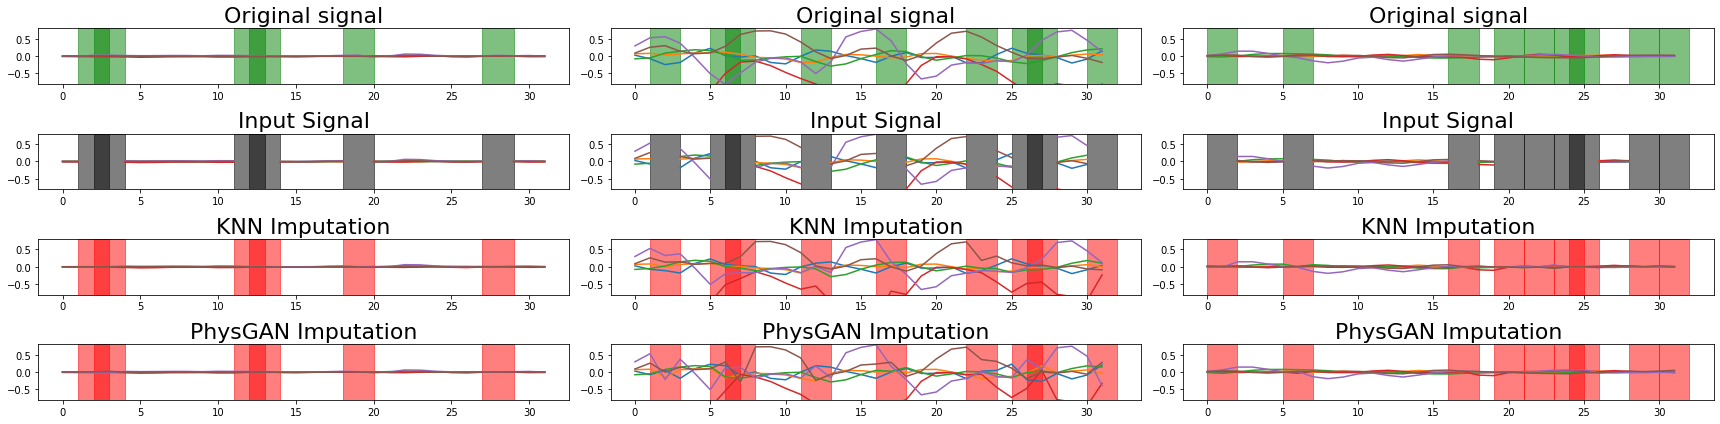

In [15]:
num_examples = 3
fig, axes = plt.subplots(4, num_examples, figsize=(24,6))
draw_alpha = 0.5
test_idxs = np.random.choice(len(test_x),size=3,replace=False)
y_min = -0.8
y_max = 0.8
for idx in range(num_examples):
    test_idx = test_idxs[idx]
    test_mask = test_masks[test_idx]
    test_x_masked = test_masked[test_idx]
    test_orig = test_x[test_idx]
    #test_result = impute_outputs[test_idx]
    
    drop_range = np.where(test_mask[:,0] != 1)
    axes[0][idx].plot(test_orig[:,:])
    axes[0][idx].set_title('Original signal', fontsize=22)


    axes[0][idx].set_ylim(y_min, y_max)

    axes[1][idx].set_title('Input Signal',fontsize=22)
    axes[1][idx].plot( test_x_masked[:,:])
    axes[1][idx].set_ylim(y_min, y_max)

    
    axes[2][idx].plot(knn_complete[test_idx,:,:])
    axes[2][idx].set_title('KNN Imputation', fontsize=22)
    axes[2][idx].set_ylim(y_min, y_max)
    
    axes[3][idx].plot(physgan_complete[test_idx,:,:])
    axes[3][idx].set_title('PhysGAN Imputation', fontsize=22)
    axes[3][idx].set_ylim(y_min, y_max)
    if mask_type == 'segment':
        axes[0][idx].axvspan(np.min(drop_range), np.max(drop_range), color='green', alpha=draw_alpha)
        axes[1][idx].axvspan(np.min(drop_range), np.max(drop_range), color='black', alpha=draw_alpha)
        axes[2][idx].axvspan(np.min(drop_range), np.max(drop_range), color='red', alpha=draw_alpha)
        axes[3][idx].axvspan(np.min(drop_range), np.max(drop_range), color='red', alpha=draw_alpha)
    else:
        for j in range(test_mask.shape[0]):
            if np.isnan(test_mask[j,0]):
                axes[0][idx].axvspan(j-1, j+1, color='green', alpha=draw_alpha)
                axes[1][idx].axvspan(j-1, j+1, color='black', alpha=draw_alpha)
                axes[2][idx].axvspan(j-1, j+1, color='red', alpha=draw_alpha)
                axes[3][idx].axvspan(j-1, j+1, color='red', alpha=draw_alpha)
plt.tight_layout()

plt.savefig('har_imputation_result_{}.png'.format(mask_type))

### MAE metric

In [16]:
def evaluate_mae(data_orig, data_completed, masks):
    mae_list = []
    for x, x_hat, m in zip(data_orig, data_completed, masks):
        mae_list.append(compute_mae(x, x_hat, m))
    return np.mean(mae_list)

In [17]:
compute_mae(test_x, knn_complete, test_masks)

0.40836951085612394

In [18]:
compute_mae(test_x, physgan_complete, test_masks)

0.5444145835660263

## Semantic metric

In [19]:
def evaluate_semantic(aux_model, data_orig, data_y, data_masked, data_completed):
    accuracy_orig = evaluate_accuracy(aux_model, data_orig, data_y)
    accuracy_masked = evaluate_accuracy(aux_model, data_masked, data_y)
    accuracy_completed = evaluate_accuracy(aux_model, data_completed, data_y)
    
    score = (accuracy_completed - accuracy_masked) /( accuracy_orig - accuracy_masked)
    print('orig: {:.2f}, masked: {:.2f}, completed: {:.2f}'.format(accuracy_orig, accuracy_masked, accuracy_completed))
    return score
    

In [20]:
evaluate_semantic(aux_model, test_x, test_y, test_masked, knn_complete)

orig: 0.89, masked: 0.19, completed: 0.88


0.98857147

In [21]:
evaluate_semantic(aux_model, test_x, test_y, test_masked, physgan_complete)

orig: 0.89, masked: 0.19, completed: 0.90


1.0085715

import pickle
with open('test_har_{}.pkl'.format(mask_type), 'wb') as fh:
    pickle.dump((test_x,test_y, test_masks, test_masked), fh)